In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import importlib
import quantbullet.research.momentum
importlib.reload(quantbullet.research.momentum)

<module 'quantbullet.research.momentum' from '/home/yiming/dev/quantbullet/src/quantbullet/research/momentum.py'>

In [115]:
from quantbullet.research.momentum import (
    compute_ex_ante_volatility, 
    compute_log_returns,
    generate_ts_momentum_signal,
)
import quantbullet.research.jump_model as jm
from quantbullet import set_figsize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
sample_series = pd.Series([1, 2, 3, 4, 5])

In [166]:
import yfinance as yf
# Define the ticker symbol
ticker_symbol = "TSLA"
# Fetch data
data = yf.download(ticker_symbol, start="2018-01-01", end="2023-12-31")

[*********************100%%**********************]  1 of 1 completed


In [62]:
log_ret = compute_log_returns(data['Adj Close'])
exante_vol = compute_ex_ante_volatility(log_ret)

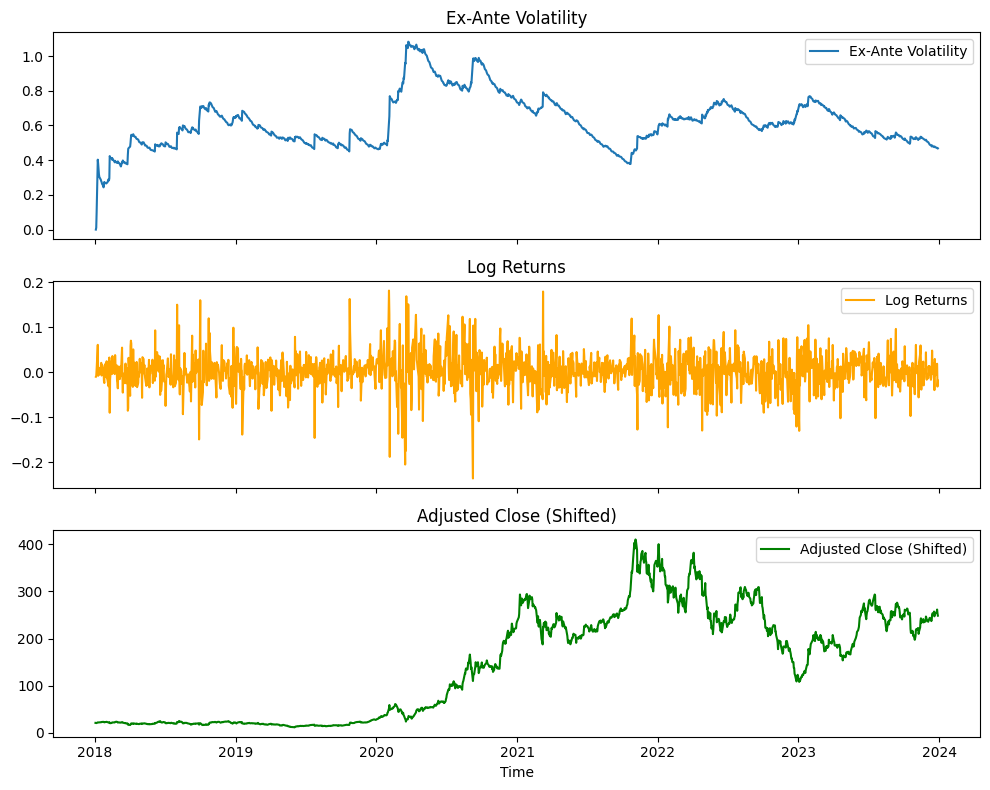

In [63]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)  # Share the x-axis (time)

axs[0].plot(exante_vol, label='Ex-Ante Volatility')
axs[0].set_title('Ex-Ante Volatility')
axs[0].legend()

axs[1].plot(log_ret, color='orange', label='Log Returns')
axs[1].set_title('Log Returns')
axs[1].legend()

axs[2].plot(data['Adj Close'], color='green', label='Adjusted Close (Shifted)')
axs[2].set_title('Adjusted Close (Shifted)')
axs[2].legend()

plt.xlabel('Time')  # Common X-axis label
plt.tight_layout()  # Adjust layout to not overlap
plt.show()

## Use 2018-2020 data to model the parameters

In [117]:
log_ret = compute_log_returns(data['Adj Close'])

In [118]:
train = log_ret[:'2020-12-31']
test = log_ret['2021-01-01':]

In [80]:
enriched_returns = jm.FeatureGenerator().enrich_features(train)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)

In [81]:
ctsJump = jm.ContinuousJumpModel()
best_states, best_loss, best_thetas = ctsJump.fit(enriched_returns, k=2, lambda_=100, n_trials=10)

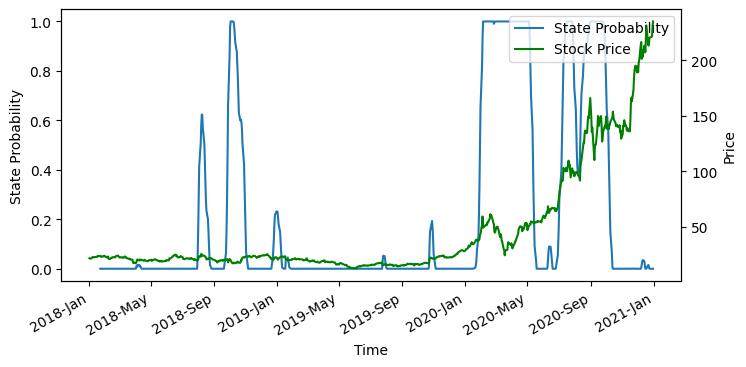

In [87]:
remapped_states, remapped_thetas = jm.arrange_state_prob_by_volatility(enriched_returns[:, 0], best_states, best_thetas, 0.5)
with set_figsize(8, 4):
    # Two states maybe flipped, so we need to rearrange them
    jm.TestingUtils().plot_state_probs(remapped_states, data['Adj Close'][:'2020-12-31'])

In [88]:
enriched_returns = jm.FeatureGenerator().enrich_features(test)
enriched_returns = jm.FeatureGenerator().standarize_features(enriched_returns)

In [381]:
probs = ctsJump.predict(enriched_returns, remapped_thetas, lambda_=10)

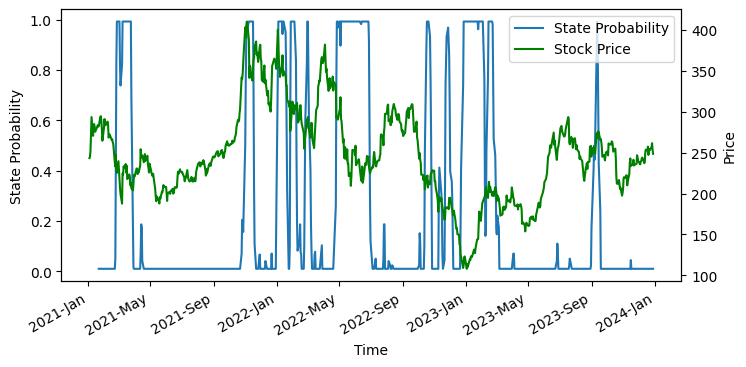

In [382]:
with set_figsize(8, 4):
    # Two states maybe flipped, so we need to rearrange them
    jm.TestingUtils().plot_state_probs(probs, data['Adj Close']['2021-1-1':])

In [102]:
exante_vol = compute_ex_ante_volatility(test)

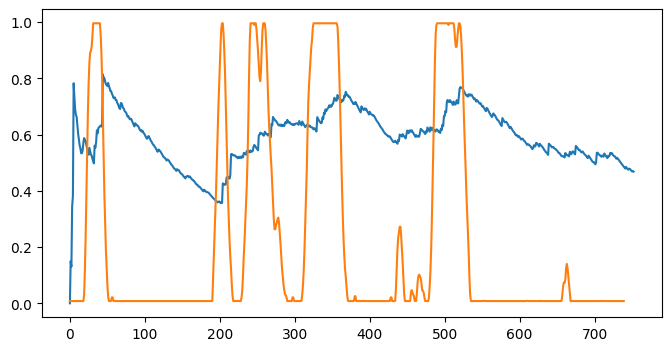

In [105]:
plt.plot(exante_vol.values)
plt.plot(probs[:, 1])

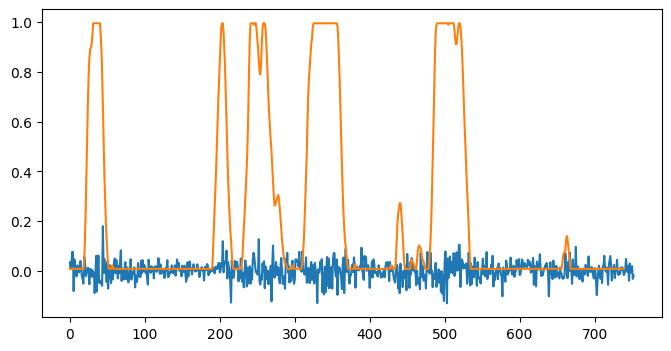

In [106]:
plt.plot(test.values)
plt.plot(probs[:, 1])

In [110]:
a = pd.Series([1, 2, 3, 4, 5])

In [112]:
a.rolling(window=2).sum()

0    NaN
1    3.0
2    5.0
3    7.0
4    9.0
dtype: float64

In [201]:
ts_mom = generate_ts_momentum_signal(test, 20)

In [137]:
train_price = data['Adj Close'][:'2020-12-31']
test_price = data['Adj Close']['2021-01-01':]

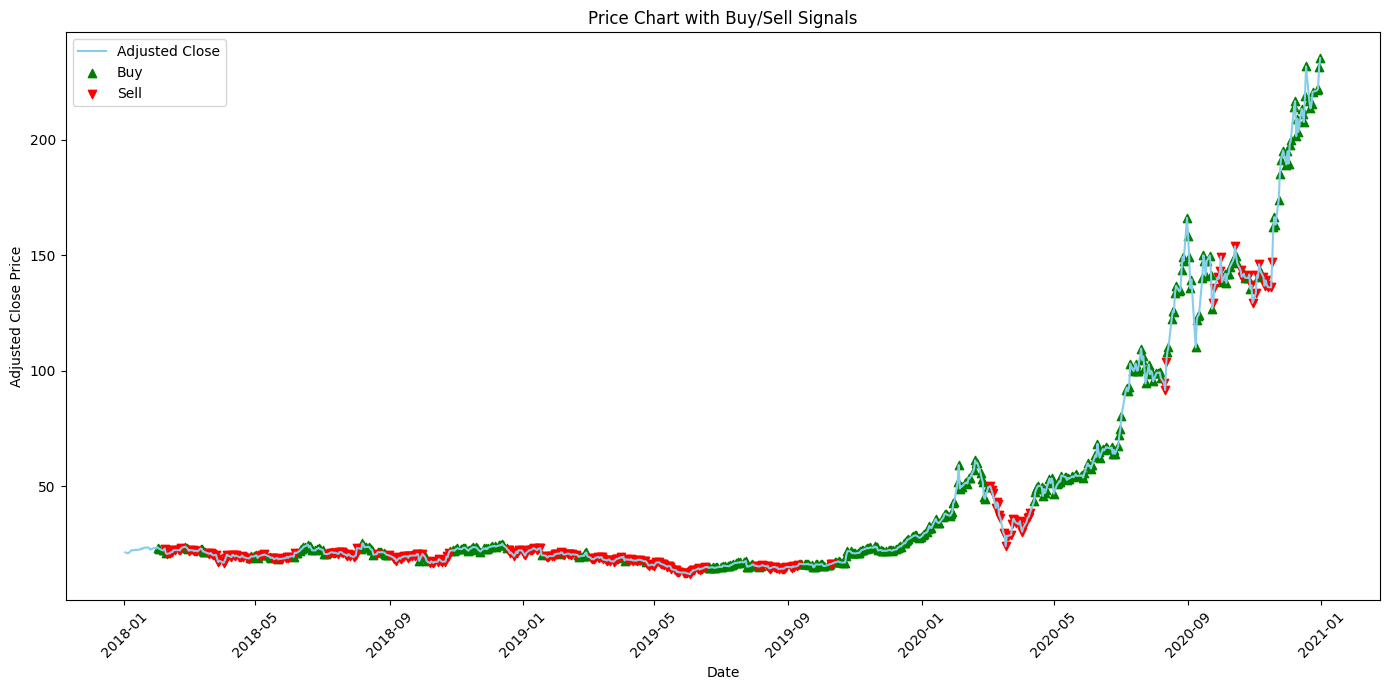

In [138]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 7))

# Price data
ax.plot(train_price.index, train_price, label='Adjusted Close', color='skyblue')

# Buy signals
buy_signals = ts_mom[ts_mom == 1]
ax.scatter(buy_signals.index, data.loc[buy_signals.index, 'Adj Close'], label='Buy', color='green', marker='^', alpha=1)

# Sell signals
sell_signals = ts_mom[ts_mom == -1]
ax.scatter(sell_signals.index, data.loc[sell_signals.index, 'Adj Close'], label='Sell', color='red', marker='v', alpha=1)

# Customization and labels
ax.set_title('Price Chart with Buy/Sell Signals')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Close Price')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Returns of the momentum strategy under regimes

In [392]:
test_ts_momentum_signal = generate_ts_momentum_signal(test, 20)
state_probs = pd.Series(probs[:, 1], index=test_ts_momentum_signal.index[13:])
# state_probs = state_probs.reindex(test_ts_momentum_signal.index)

In [393]:
df = pd.DataFrame({'ts_momentum_signal': test_ts_momentum_signal,
                   'close': test_price,
                   'state_probs': state_probs,
                   'log_return': test,
                   'return': np.exp(test) - 1})

In [394]:
df['strategy_return'] = df['ts_momentum_signal'] * df['return']
df['strategy_cum_return'] = (1 + df['strategy_return']).cumprod()

In [395]:
df['state_0_strategy_return'] = df['ts_momentum_signal'] * df['return'] * np.where(df['state_probs'] < 0.5, 1, np.nan)
df['state_0_strategy_cum_return'] = (1 + df['state_0_strategy_return'].fillna(0)).cumprod()
df['state_1_strategy_return'] = df['ts_momentum_signal'] * df['return'] * np.where(df['state_probs'] >= 0.5, 1, np.nan)
df['state_1_strategy_cum_return'] = (1 + df['state_1_strategy_return'].fillna(0)).cumprod()

In [396]:
def compute_sharp_ratio(returns, annualization_factor=252):
    return np.sqrt(annualization_factor) * returns.mean() / returns.std()

def compute_max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    return (cum_returns / cum_returns.cummax() - 1).min()

def print_metrics(returns, annualization_factor=252):
    print(f'Annualized Return: {returns.mean() * annualization_factor:.2%}')
    print(f'Annualized Volatility: {returns.std() * np.sqrt(annualization_factor):.2%}')
    print(f'Sharp Ratio: {compute_sharp_ratio(returns, annualization_factor):.2f}')
    print(f'Max Drawdown: {compute_max_drawdown(returns):.2%}')
    print(f'Number of Trades: {returns[returns != 0].count()}')

In [397]:
a = pd.Series([1, 2, 3, 4, 5, np.nan])

In [398]:
print_metrics(df['strategy_return'])

Annualized Return: 48.48%
Annualized Volatility: 58.65%
Sharp Ratio: 0.83
Max Drawdown: -42.95%
Number of Trades: 732


In [399]:
print_metrics(df['state_0_strategy_return'])

Annualized Return: 56.46%
Annualized Volatility: 49.64%
Sharp Ratio: 1.14
Max Drawdown: -43.66%
Number of Trades: 570


In [400]:
print_metrics(df['state_1_strategy_return'])

Annualized Return: 20.59%
Annualized Volatility: 82.98%
Sharp Ratio: 0.25
Max Drawdown: -52.33%
Number of Trades: 162


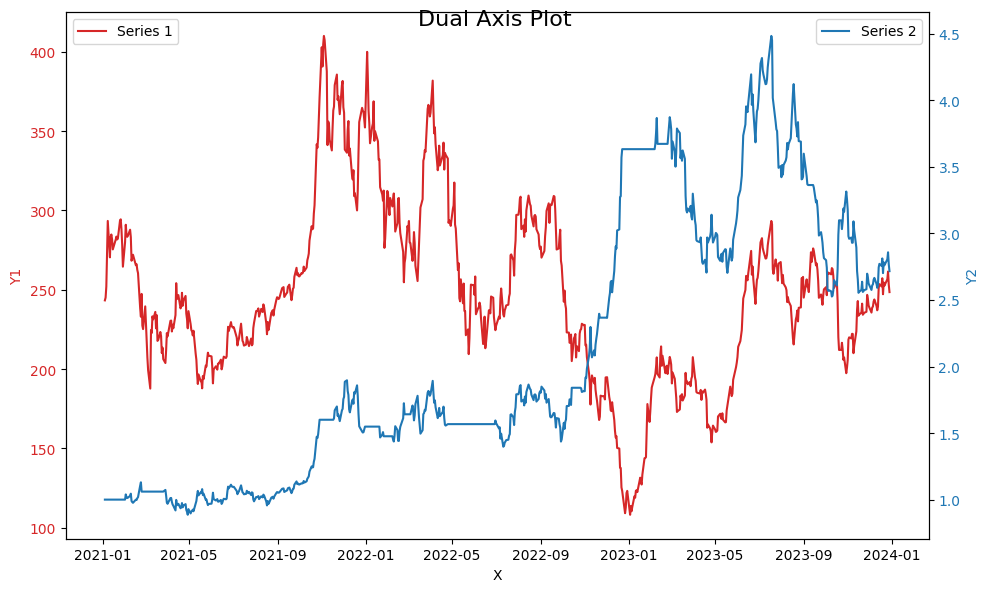

In [401]:
plot_dual_axis(df['close'], df['state_0_strategy_cum_return'])